# Exercise 4
Task:
- Implement DMDc as shown in Example 3.6
- Test script on data provided in handout 4
- Modify number of singular values and analyze effect on approximation quality





In [ ]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from utils import dmd

In [39]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Task 1

a. Turn off the input in the file generate_data. Use the resulting simulation data to perform a DMD using the SVD. Herein adjust the rank r to achieve model order reduction

b. Set up the solution of the obtained linear rank-r linear system and compare the solution to the original solution from generate_data and the one for the full rank DMD.

In [40]:
@jax.jit
def piecewise_step(t: jax.Array) -> jax.Array:
    return (
        (t >= 1).astype(float)
        - 2 * (t >= 2).astype(float)
        -     (t >= 3).astype(float)
        + 4 * (t >= 4).astype(float)
        - 2 * (t >= 6).astype(float)
    )

In [41]:
# Generate Data
z = jnp.linspace(0, 1, 201)
t = jnp.linspace(0, 10, 1001)
u = piecewise_step(t)

p = dmd.PDEParams(
    d=0.2, c=-1.0, fun=lambda x, dx, z, t: -0.2 * x + 5 * jnp.sin(x), t=t, u=u, z=z
)

x, z, t = dmd.solve_pde_implicit(p)
x = jnp.array(x)

x_ = x[:-1].T       
x_prime = x[1:].T 
x_0 = x_[:, 0]   

In [59]:
a, phi, lam = dmd.dmd(x_,x_prime, 6)
timesteps = jnp.arange(0,1000)
result = dmd.dmd_reconstruction(phi, lam,x_0,timesteps)


In [100]:
u = u[:x.shape[0]-1].reshape(1,-1)
a_c, b_c, phi_c, lam_c = dmd.dmdc(x_,x_prime,u, 6)

In [101]:
result_c = dmd.dmdc_reconstruction(x_0, u.T, a_c, b_c, phi_c)

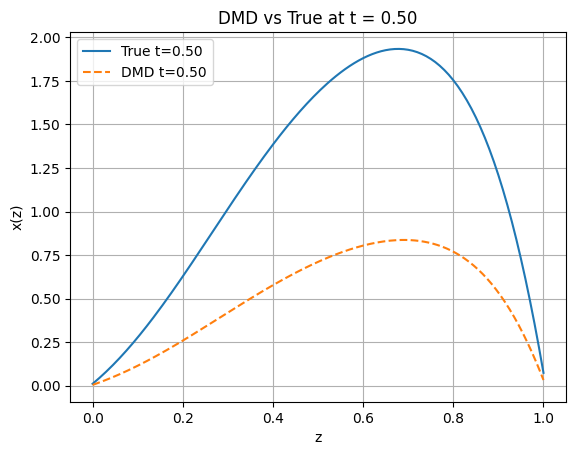

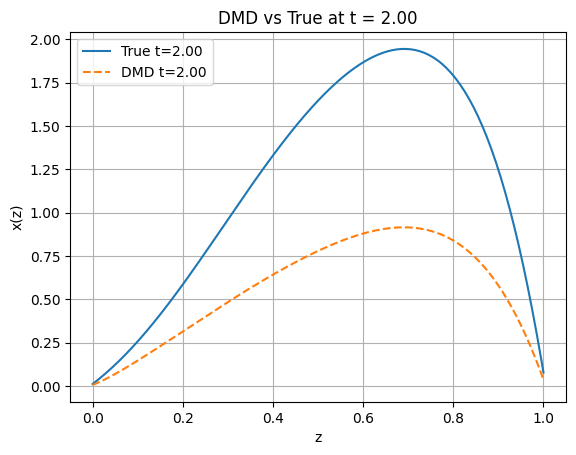

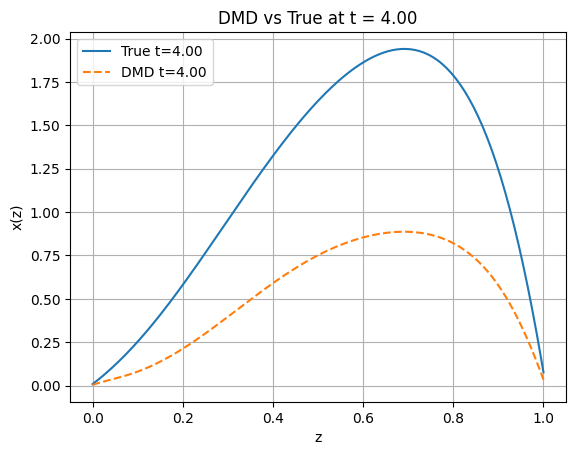

In [102]:
for i in [50, 200, 400]:
    plt.plot(z, x[i], label=f"True t={t[i]:.2f}")
    plt.plot(z, result_c.T[:, i], "--", label=f"DMD t={t[i]:.2f}")
    plt.xlabel("z")
    plt.ylabel("x(z)")
    plt.legend()
    plt.title("DMD vs True at t = {:.2f}".format(t[i]))
    plt.grid(True)
    plt.show()


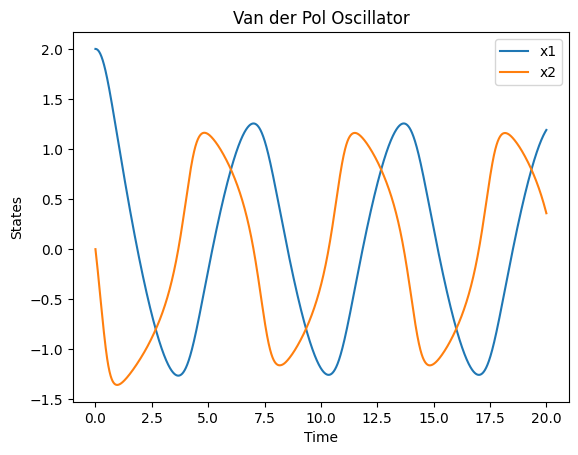

In [121]:
from scipy.integrate import solve_ivp   
def solve_vanderpol(t,l,c,a,b,x0):
    """
    Solves the Van der Pol oscillator ODE

    System equations:
        dx_1 = x[1] / p['L']
        dx_2 = (-x[0] - p['a'] * x[1] * (x[1]**2 - p['b'])) / p['C']

    Args:
        t (numpy.ndarray): time vector
        l (float): inductance
        c (float): capacity
        a (float): parameter a
        b (float): parameter b
        x0 (numpy.ndarray): initial state

    Function Outputs:
        t (numpy.ndarray): time vector
        x (numpy.ndarray): numerical solution
    """
    # Define the system ODE
    def vanderpol_ode(t,x,a,b,c,l):
        """
        Van der Pol oscillator ODE
        
        Args:
            t (float): time
            x (numpy.ndarray): state vector
            a (float): parameter a
            b (float): parameter b
            c (float): parameter c
            l (float): parameter l
        """
        dx1 = x[1] / l
        dx2 = (-x[0] - a * x[1] * (x[1]**2 - b)) / c
        return [dx1, dx2]

    # Solve the ODE
    sol = solve_ivp(vanderpol_ode, [t[0], t[-1]], x0, t_eval=t, args=(a,b,c,l))

    # Return the time vector and numerical solution
    return sol.t, sol.y


# Params for the Van der Pol oscillator
t = jnp.linspace(0, 20, 5001)
l = 1.0
c = 1.0
a = 1.0
b = 1.0
x0 = jnp.array([2.0, 0.0])

t, x = solve_vanderpol(t,l,c,a,b,x0)

x1 = x[0, :]
x2 = x[1, :]

plt.figure()
plt.plot(t, x1, label='x1')
plt.plot(t, x2, label='x2')
plt.xlabel('Time')
plt.ylabel('States')
plt.title('Van der Pol Oscillator')
plt.legend()
plt.show()


(400, 4801) (400, 4801)


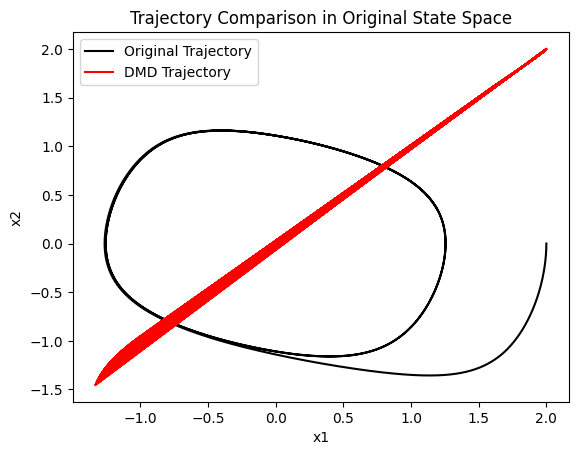

In [ ]:
# Define Hankel matrix
hrow = 200
def hankel(hrow, x, t): 
    """ Create Hankel matrices from a time series x using delay embedding.
        For a data matrix x of shape (n, T), this function creates
        X   = [ x[:,0:m]; x[:,1:m+1]; ...; x[:,hrow-1:m+hrow-1] ]
        Xp  = [ x[:,1:m+1]; x[:,2:m+2]; ...; x[:,hrow:m+hrow] ]
        where m = T - hrow + 1.

    Args:
        hrow (int): number of delays (rows per block)
        x (jax.numpy.ndarray): data matrix of shape (n, T)
        t (jax.numpy.ndarray): time vector (length T)

    Returns:
        X (jax.numpy.ndarray): Hankel matrix of shape (n*hrow, m)
        Xp (jax.numpy.ndarray): time-shifted Hankel matrix of shape (n*hrow, m)
    """
    T = x.shape[1]
    m = T - hrow  # Use T - hrow so that both Hankel matrices have the same number of columns.
    X = jnp.concatenate([x[:, i:i+m] for i in range(hrow)], axis=0)
    Xp = jnp.concatenate([x[:, i+1:i+m+1] for i in range(hrow)], axis=0)
    return X, Xp

Xtd, Xtdp = hankel(hrow,x,t)
print(Xtd.shape, Xtdp.shape)
# Compute DMD
# a,b,phi,lam = dmd.dmdc(Xtd, Xtdp, r)  # Use corrected DMD function

a, phi, lam = dmd.dmd(Xtd, Xtdp, 3)

x0_hankel = Xtd[:, 0]  # shape is (n*hrow,)


sim = dmd.dmd_reconstruction(phi, lam, x0_hankel, jnp.arange(0, 5000))
x_recon = sim[:2, :]


plt.figure() 
plt.plot(x[0, :], x[1, :], 'k-', label='Original Trajectory') # original simulation 
plt.plot(x_recon[0, :].real, x_recon[1, :].real, 'r-', label='DMD Trajectory') 
plt.xlabel('x1') 
plt.ylabel('x2') 
plt.title('Trajectory Comparison in Original State Space') 
plt.legend() 
plt.show()